# Course project

This notebook includes the steps to optimize the capacity and dispatch of generators in a stylized energy system. It has been prepared to serve as a tutorial for a simple PyPSA model representing the energy system in one country, city or region. 
 

For the (optional) project of the course [Integrated Energy Grids](https://kurser.dtu.dk/course/2024-2025/46770?menulanguage=en) you need to deliver a report including the sections described at the end of this notebook.

Please, review the [PyPSA tutorial](https://martavp.github.io/integrated-energy-grids/intro-pypsa.html) before starting this project.

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `pypsa` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

In [85]:
pip install pypsa


In [86]:
import pandas as pd
import pypsa




We start by creating the network. In this example, the country is modelled as a single node, so the network includes only one bus.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case Denmark (DNK), and add one node (electricity bus) to the network.

In [87]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

network.add("Bus",
            "electricity bus")

network.add("Bus",
            "heating bus")

network.snapshots


DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

The demand is represented by the historical electricity demand in 2015 with hourly resolution.

The file with historical hourly electricity demand for every European country is available in the data folder.

The electricity demand time series were obtained from ENTSOE through the very convenient compilation carried out by the Open Power System Data (OPSD). https://data.open-power-system-data.org/time_series/

In [106]:
# load electricity demand and heating demand data
df_elec = pd.read_csv('electricity_demand.csv', sep=';', index_col=0) # in MWh
df_heat = pd.read_csv('heat_demand.csv', sep=';', index_col=0)
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
df_heat.index = pd.to_datetime(df_heat.index) #change index to datatime
country='NLD'
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    11338.0
2015-01-01 01:00:00+00:00    10917.0
2015-01-01 02:00:00+00:00    10473.0
2015-01-01 03:00:00+00:00    10200.0
2015-01-01 04:00:00+00:00    10182.0
Name: NLD, dtype: float64


In [ ]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)

network.add("Load",
            "load h",
            bus="heating bus",
            p_set=df_heat[country].values)

Index(['load h'], dtype='object')

Print the load time series to check that it has been properly added (you should see numbers and not 'NaN')

In [133]:
network.loads_t.p_set

Load,load,load h
snapshot,,
2015-01-01 00:00:00,11338.0,30208.769643
2015-01-01 01:00:00,10917.0,30178.483595
2015-01-01 02:00:00,10473.0,30656.801254
2015-01-01 03:00:00,10200.0,31221.195229
2015-01-01 04:00:00,10182.0,31682.524876
...,...,...
2015-12-31 19:00:00,12958.0,23569.329326
2015-12-31 20:00:00,12263.0,23954.753254
2015-12-31 21:00:00,11772.0,24256.040638


In the optimization, we will minimize the annualized system costs.

We will need to annualize the cost of every generator, we build a function to do it.

In [134]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


We include solar PV and onshore wind generators.

The capacity factors representing the availability of those generators for every European country can be downloaded from the following repositories (select 'optimal' for PV and onshore for wind).

https://zenodo.org/record/3253876#.XSiVOEdS8l0

https://zenodo.org/record/2613651#.XSiVOkdS8l0

We include also Open Cycle Gas Turbine (OCGT) generators

The cost assumed for the generators are the same as in Table 1 in the paper https://doi.org/10.1016/j.enconman.2019.111977 (open version:  https://arxiv.org/pdf/1906.06936.pdf)

In [183]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
print("CF wind", CF_wind)
#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values)

network.add("Link",
            "resistive_heater",
            bus0="electricity bus",
            bus1="heating bus",
            efficiency=0.9,
             p_nom=10000,
            p_nom_extendable=True,
            capital_cost=0)


# add solar PV generator
df_solar = pd.read_csv('pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
print("CF solar", CF_solar)
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)



# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)


# plot the capacity factor
daily_mean_pv = df_solar[country].loc['2015'].resample('ME').mean()
#daily_mean_pv.plot(kind='line', ylabel='Capacity Factor solar PV', color='orange')
#print('Average solar annual mean {:.2f}, \nNormalized Standar deviation {:.2f} %'.format(daily_mean_pv.mean(), daily_mean_pv.std() / daily_mean_pv.mean()))

# plot the capacity factor
daily_mean_wind = df_onshorewind[country].loc['2015'].resample('ME').mean()
#daily_mean_wind.plot(kind='line', ylabel='Capacity Factor Wind', color='blue')
#print('Average wind annual mean {:.2f}, \nNormalized Standar deviation {:.2f} %'.format(daily_mean_wind.mean(), daily_mean_wind.std() / daily_mean_wind.mean()))



CF wind utc_time
2015-01-01 00:00:00+00:00    0.360
2015-01-01 01:00:00+00:00    0.383
2015-01-01 02:00:00+00:00    0.417
2015-01-01 03:00:00+00:00    0.432
2015-01-01 04:00:00+00:00    0.443
                             ...  
2015-12-31 19:00:00+00:00    0.448
2015-12-31 20:00:00+00:00    0.465
2015-12-31 21:00:00+00:00    0.451
2015-12-31 22:00:00+00:00    0.439
2015-12-31 23:00:00+00:00    0.447
Name: NLD, Length: 8760, dtype: float64


CF solar utc_time
2015-01-01 00:00:00+00:00    0.0
2015-01-01 01:00:00+00:00    0.0
2015-01-01 02:00:00+00:00    0.0
2015-01-01 03:00:00+00:00    0.0
2015-01-01 04:00:00+00:00    0.0
                            ... 
2015-12-31 19:00:00+00:00    0.0
2015-12-31 20:00:00+00:00    0.0
2015-12-31 21:00:00+00:00    0.0
2015-12-31 22:00:00+00:00    0.0
2015-12-31 23:00:00+00:00    0.0
Name: NLD, Length: 8760, dtype: float64


Print the generator Capacity factor time series to check that it has been properly added (you should see numbers and not 'NaN')

In [188]:
network.generators_t.p_max_pu
print(network.loads_t.p["load h"])  # Heating demand
print(network.generators_t.p)
print("Links in the network:", network.links.index)

print(network.links_t.p["resistive_heater"])  # Power output from resistive heater




snapshot
2015-01-01 00:00:00    30208.769643
2015-01-01 01:00:00    30178.483595
2015-01-01 02:00:00    30656.801254
2015-01-01 03:00:00    31221.195229
2015-01-01 04:00:00    31682.524876
                           ...     
2015-12-31 19:00:00    23569.329326
2015-12-31 20:00:00    23954.753254
2015-12-31 21:00:00    24256.040638
2015-12-31 22:00:00    24448.970640
2015-12-31 23:00:00    24529.967002
Name: load h, Length: 8760, dtype: float64
Generator             onshorewind  solar          OCGT
snapshot                                              
2015-01-01 00:00:00  15645.111519   -0.0  25901.658124
2015-01-01 01:00:00  16644.660310   -0.0  24450.823285
2015-01-01 02:00:00  18122.254176   -0.0  23007.547078
2015-01-01 03:00:00  18774.133822   -0.0  22647.061407
2015-01-01 04:00:00  19252.178897   -0.0  22612.345979
...                           ...    ...           ...
2015-12-31 19:00:00  19469.472112   -0.0  17057.857214
2015-12-31 20:00:00  20208.269045   -0.0  16009.484209
20

c:\Users\const\anaconda\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\const\anaconda\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

c:\Users\const\anaconda\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\const\anaconda\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead



AttributeError: p

We find the optimal solution using Gurobi as solver.

In this case, we are optimizing the installed capacity and dispatch of every generator to minimize the total system cost.

In [ ]:
network.optimize()

Index(['resistive_heater'], dtype='object', name='Link')
Index(['electricity bus', 'heating bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 23.45it/s]
INFO:linopy.io: Writing time: 1.35s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35044 primals, 87604 duals
Objective: 1.45e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='snapshot'>

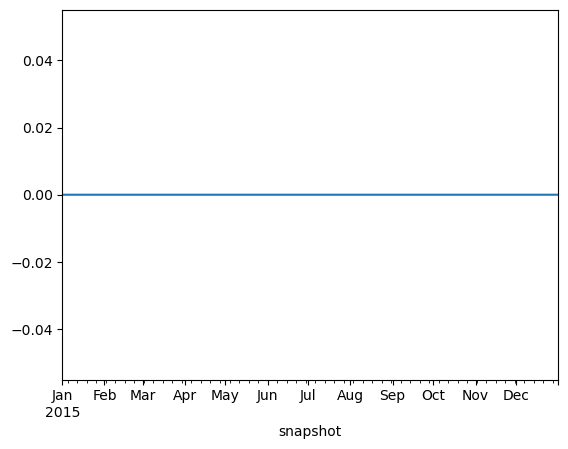

In [ ]:
network.links_t.p0["resistive_heater"].plot()
#print(network.links_t.p['resistive_heater'])



The message ('ok' , 'optimal") indicates that the optimizer has found an optimal solution.

The total cost can be read from the network objetive.

In [ ]:
print(network.objective/1000000) #in 10^6 €

14460.264289217383


The cost per MWh of electricity produced can also be calculated.

In [ ]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load      127.684592
load h    104.179918
dtype: float64


The optimal capacity for every generator can be shown.

In [ ]:
network.generators.p_nom_opt # in MW

Generator
onshorewind    43458.643108
solar          20117.761173
OCGT           56461.432192
Name: p_nom_opt, dtype: float64

We can plot now the dispatch of every generator during the first week of the year and the electricity demand.
We import the matplotlib package which is very useful to plot results.

We can also plot the electricity mix.

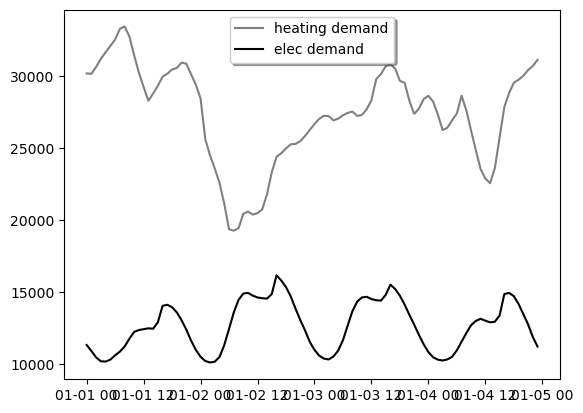

In [ ]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load h'][0:96], color='grey', label='heating demand')
plt.plot(network.loads_t.p['load'][0:96], color='black', label='elec demand')
#plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
#plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
#plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

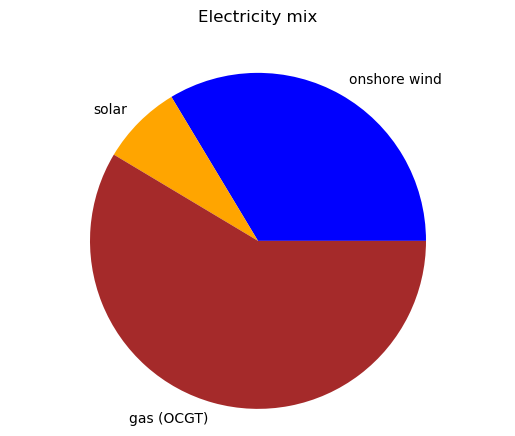

In [ ]:
labels = ['onshore wind',
          'solar',
          'gas (OCGT)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [ ]:
# Example data for heating sources (you might need to adapt this to your model and variables)
labels_heating = ['resistive heater', 'gas heating']  # Adjust if you have other heating sources
sizes_heating = [network.links_t.p['resistive_heater'].sum(),  # Total power output from resistive heater
                 network.generators_t.p['OCGT'].sum()]  # Replace 'other_heating' with actual sources if any

colors_heating = ['blue', 'brown']  # Adjust colors as needed

# Create the pie chart for heating generation mix
plt.pie(sizes_heating,
        colors=colors_heating,
        labels=labels_heating,
        wedgeprops={'linewidth': 0})
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

plt.title('Heating Generation Mix', y=1.07)
plt.show()


c:\Users\const\anaconda\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\const\anaconda\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

c:\Users\const\anaconda\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\const\anaconda\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

c:\Users\const\anaconda\Lib\site-packages\executing\executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

c:\Users\const\anaconda\Lib\ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

c:\Users\const\anaconda\Lib\site-packages\executi

AttributeError: p

In [ ]:
# Check available links and their names
print(network.links)

# Check available generators and their names
print(network.generators)

                             bus0         bus1 type carrier  efficiency  \
Link                                                                      
resistive_heater  electricity bus  heating bus           AC         0.9   

                  active  build_year  lifetime  p_nom  p_nom_mod  ...  \
Link                                                              ...   
resistive_heater    True           0       inf    0.0        0.0  ...   

                  shut_down_cost  min_up_time  min_down_time  up_time_before  \
Link                                                                           
resistive_heater             0.0            0              0               1   

                  down_time_before  ramp_limit_up  ramp_limit_down  \
Link                                                                 
resistive_heater                 0            NaN              NaN   

                  ramp_limit_start_up  ramp_limit_shut_down  p_nom_opt  
Link                         

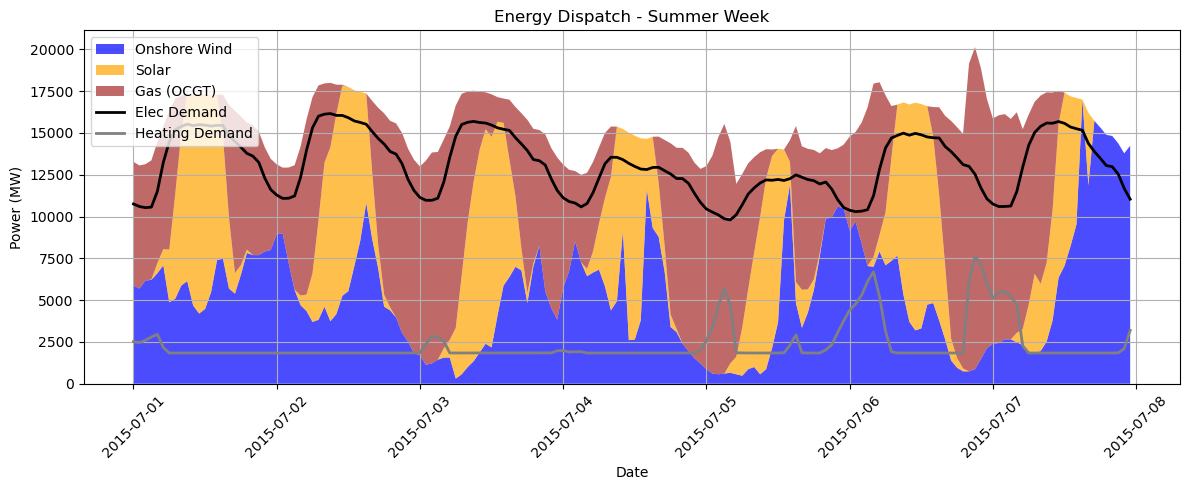

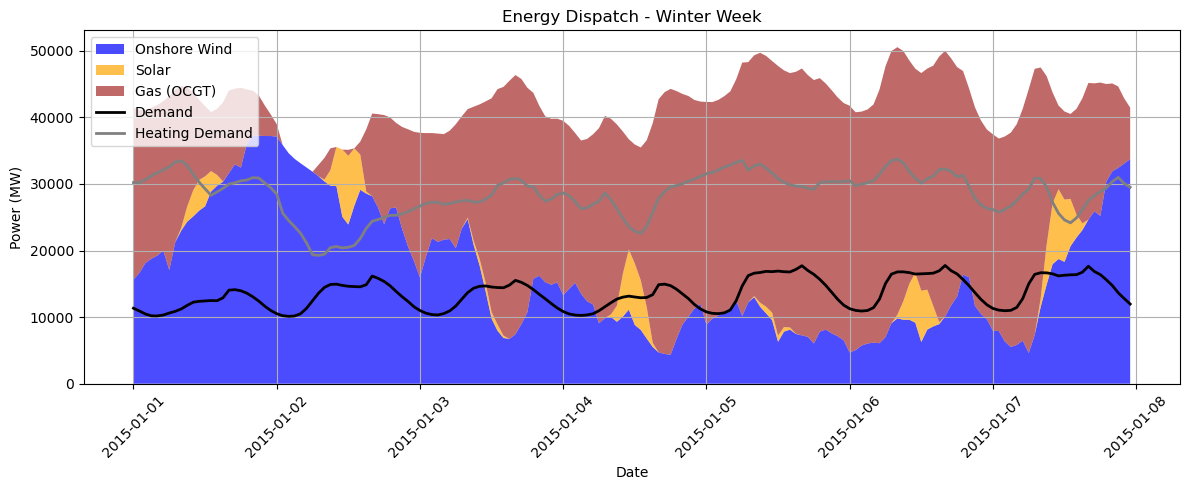

In [ ]:

# Define time ranges for summer and winter (assuming hourly data for a full year)
summer_week = pd.date_range("2015-07-01", periods=168, freq="h")
winter_week = pd.date_range("2015-01-01", periods=168, freq="h")

# Extract generation data for summer and winter weeks
dispatch_summer = network.generators_t.p.loc[summer_week]
dispatch_winter = network.generators_t.p.loc[winter_week]

# Plot summer dispatch
plt.figure(figsize=(12, 5))
plt.stackplot(dispatch_summer.index,
              dispatch_summer["onshorewind"],
              dispatch_summer["solar"],
              dispatch_summer["OCGT"],
              labels=["Onshore Wind", "Solar", "Gas (OCGT)"],
              colors=["blue", "orange", "brown"], alpha=0.7)
plt.plot(network.loads_t.p.loc[summer_week, 'load'], color='black', linestyle='-', linewidth=2, label='Elec Demand')
plt.plot(network.loads_t.p.loc[summer_week, 'load h'], color='grey', linestyle='-', linewidth=2, label='Heating Demand')

plt.title("Energy Dispatch - Summer Week")
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot winter dispatch
plt.figure(figsize=(12, 5))
plt.stackplot(dispatch_winter.index,
              dispatch_winter["onshorewind"],
              dispatch_winter["solar"],
              dispatch_winter["OCGT"],
              labels=["Onshore Wind", "Solar", "Gas (OCGT)"],
              colors=["blue", "orange", "brown"], alpha=0.7)
plt.plot(network.loads_t.p.loc[winter_week, 'load'], color='black', linestyle='-', linewidth=2, label='Demand')
plt.plot(network.loads_t.p.loc[winter_week, 'load h'], color='grey', linestyle='-', linewidth=2, label='Heating Demand')

plt.title("Energy Dispatch - Winter Week")
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
heat_output = network.links_t.p1[["resistive_heater"]]
print(heat_output)
heat_output.to_csv('file')


Link                 resistive_heater
snapshot                             
2015-01-01 00:00:00               0.0
2015-01-01 01:00:00               0.0
2015-01-01 02:00:00               0.0
2015-01-01 03:00:00               0.0
2015-01-01 04:00:00               0.0
...                               ...
2015-12-31 19:00:00               0.0
2015-12-31 20:00:00               0.0
2015-12-31 21:00:00               0.0
2015-12-31 22:00:00               0.0
2015-12-31 23:00:00               0.0

[8760 rows x 1 columns]


We can add a global CO2 constraint and solve again.

In [ ]:
co2_limit=1000000 #tonCO2
#look at the emissions the netherlands emitted in 2015, and put a cap
#network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)
network.optimize()

IndentationError: unexpected indent (2651700600.py, line 4)

In [ ]:
network.generators.p_nom_opt #in MW

Generator
onshorewind    1.212220e+06
solar          1.554531e+05
OCGT           4.387860e+04
Name: p_nom_opt, dtype: float64

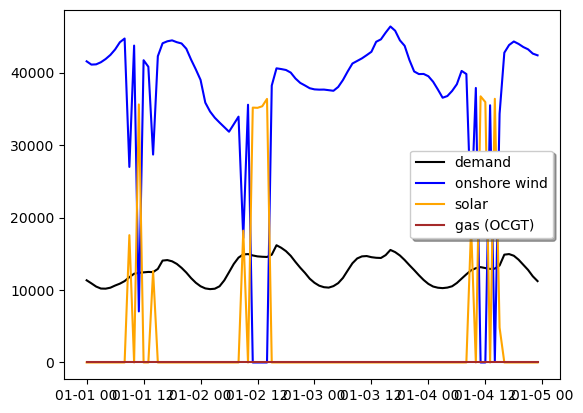

In [ ]:
plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

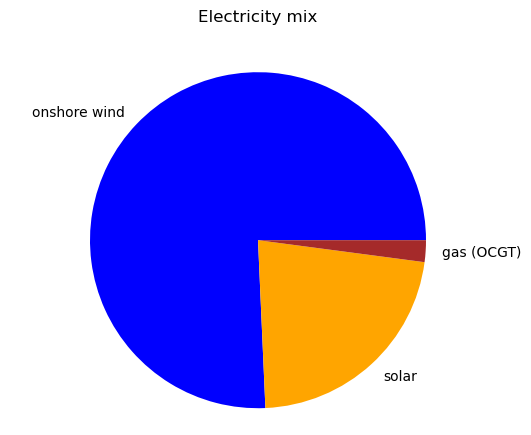

In [ ]:
labels = ['onshore wind', 'solar', 'gas (OCGT)' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors = ['blue', 'orange', 'brown']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

# PROJECT INSTRUCTIONS


Based on the previous example, you are asked to carry out the following tasks:

A. Choose a different country/region/city/system and calculate the optimal capacities for renewable and non-renewable generators. You can add as many technologies as you want. Remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. Use the duration curves or the capacity factor to investigate the contribution of different technologies.

B. Investigate how sensitive the optimum capacity mix is to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer to the emissions allowance to that historical data.

C. Investigate how sensitive your results are to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years.

D. Add some storage technology/ies and investigate how they behave and what their impact is on the optimal system configuration. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.)

E. Select one target for decarbonization (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your results.

F. Connect your country with, at least, two neighbouring countries. You can connect them using HVAC lines, HVDC links or gas pipelines. Use a linear representation of power flow or gas flow. 
You can assume that the generation capacities in the neighbouring countries are fixed or optimize the whole system. You can also include fixed interconnection capacities or optimize them with the generators' capacities. Discuss your results.

G. Connect the electricity sector with, at least, another sector( e.g. heating or transport), and co-optimize all the sectors. Discuss your results.

H. Finally, select one topic that is under discussion in your region. Design and implement some experiment to obtain relevant information regarding that topic. E.g.

- What are the consequences if Denmark decides not to install more onshore wind?

- Would it be more expensive if France decides to close its nuclear power plants?

- What will be the main impacts of the Viking link?

- How does gas scarcity impact the optimal system configuration?

**Write a short report (maximum length 10 pages) in groups of 4 students including your main findings.**

# Hints

_HINT 1: You can add a link with the following code_

The efficiency will be 1 if you are connecting two countries and different from one if, for example, you are connecting the electricity bus to the heating bus using a heat pump.
Setting p_min_pu=-1 makes the link reversible.


In [ ]:
network.add("Link",
             'country a - country b',
             bus0="electricity bus country a",
             bus1="electricity bus country b",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             length=600, # length (in km) between country a and country b
             capital_cost=400*600) # capital cost * length

Index(['country a - country b'], dtype='object')
Index(['country a - country b'], dtype='object')


Index(['country a - country b'], dtype='object')

_HINT 2: You can check the KKT multiplier associated with the constraint with the following code_

In [ ]:
print(network.global_constraints.constant) # CO2 limit (constant in the constraint)
print(network.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

GlobalConstraint
co2_limit    1000000.0
Name: constant, dtype: float64
GlobalConstraint
co2_limit   -51268.16899
Name: mu, dtype: float64


_HINT 3: You can add a H2 store connected to the electricity bus via an electrolyzer and a fuel cell with the following code_

In [ ]:
#Create a new carrier
network.add("Carrier",
              "H2")

#Create a new bus
network.add("Bus",
          "H2",
          carrier = "H2")

#Connect the store to the bus
network.add("Store",
          "H2 Tank",
          bus = "H2",
          e_nom_extendable = True,
          e_cyclic = True,
          capital_cost = annuity(25, 0.07)*57000*(1+0.011))

#Add the link "H2 Electrolysis" that transport energy from the electricity bus (bus0) to the H2 bus (bus1)
#with 80% efficiency
network.add("Link",
          "H2 Electrolysis",
          bus0 = "electricity bus",
          bus1 = "H2",
          p_nom_extendable = True,
          efficiency = 0.8,
          capital_cost = annuity(25, 0.07)*600000*(1+0.05))

#Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
          "H2 Fuel Cell",
          bus0 = "H2",
          bus1 = "electricity bus",
          p_nom_extendable = True,
          efficiency = 0.58,
          capital_cost = annuity(10, 0.07)*1300000*(1+0.05))


Index(['H2 Fuel Cell'], dtype='object')

_HINT 4: You can get inspiration for plotting the flows in the network in the following example_

https://pypsa.readthedocs.io/en/latest/examples/flow-plot.html